# Multi Layer Perceptron

This in an implementation of a MLP from scratch. This neural network is designed with 2 layers, including one hidden layer and used to perform binary classification.

In [367]:
# Imports
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn import model_selection
import copy

We're going to perform a classification on scikit learn's make_moons dataset. This dataset represents points arranged along two interleaving half circles with more or less noise. The data is shown below.

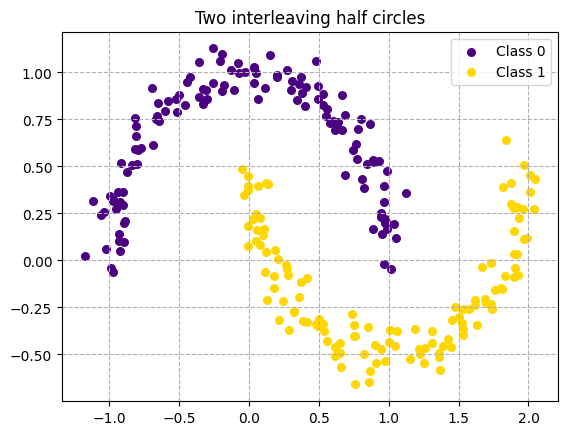

In [368]:
X, y = datasets.make_moons(250, noise = 0.07)

# Plot our data
plt.figure()
plt.scatter(X[y == 0, 0], X[y == 0, 1], s=30, color='indigo', label='Class 0')
plt.scatter(X[y == 1, 0], X[y == 1, 1], s=30, color='gold', label='Class 1')
plt.title('Two interleaving half circles')
plt.grid(True,which="both", linestyle='--')
plt.legend()
plt.show()

In [369]:
# Split our data into both train and test set
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

We're now going to define some useful functions for our model. In particular, as our model performs a binary classification, we will minimise the binary cross-entropy for each neuron and we will use a sigmoid activation. 
Moreover, to prevent the gradient vanishing during back propagation we will use Relu activation between layers.

In [370]:
def ReLu(x):
    """ Relu activation function"""

    zero = np.zeros((x.shape[0],x.shape[1]))
    return np.maximum(zero,x)


def Sigmoid(x):
    """Sigmoid activation function"""

    return 1 / (1 + np.exp(-x))


def dx_Relu(x):
    """Compute the derivative of the Relu activation function"""

    x[x<=0] = 0
    x[x>0] = 1
    return x

We now define the cost function as well as the accuracy function in order to test our model and check if everything goes well.

In [371]:
def Cost(hat_y,y):
    """ Compute the cost as the mean of the Loss (binary cross entropy)

    Args:
        hat_y (np.array): Predicted label, size (n, 1)
        y (np.array): True label, size(n, 1)

    Returns:
        np.array: Cost 
    """

    
    loss = - y * np.log(hat_y) - (1 - y) * np.log(1 - hat_y)

    cost = np.sum(loss) / len(y)

    return cost

def accuracy(hat_y,y):
    """Compute the accuracy of the model

    Args:
        hat_y (np.array): Predicted label, size (n, 1)
        y (np.array): True label, size(n, 1)

    Returns:
        float: Accuracy
    """

    y_prime = copy.deepcopy(hat_y)

    y_prime[y_prime<=0.5] = 0
    y_prime[y_prime>0.5] = 1

    res = np.sum(y_prime == y)
    
    return res/len(y)*100

### MLP Class and Gradient Descents

In this class are define both the MLP and the gradient descents that we will use. The MLP architecture is as follows : 

$$ 
\begin{align*}
&\text{Input : }\mathbf{x}  \\
&\text{Layer[1]:} \quad \mathbf{x} W^{[1]} + b^{[1]} \rightarrow z^{[1]} \rightarrow f(z^{[1]}) \rightarrow a^{[1]} \\
&\text{Layer[2]:} \quad a^{[1]} W^{[2]} + b^{[2]} \rightarrow z^{[2]} \rightarrow \sigma(z^{[2]}) \rightarrow a^{[2]} \\
&\text{Loss:} \quad \mathcal{L}(\hat{y} = a^{[2]}, y)
\end{align*}
$$ 

Where $\mathcal{L} = - \left( y \log(\hat{y}) + (1-y) \log(1-\hat{y}) \right),$ $\sigma$ is the sigmoid and $f$ is Relu.

In [ ]:
class MLP():

    """Representation of a Multi-Layer Perceptron with 1 hidden layer

    Attributes
    ----------
    w1, w2, b1, b2: np.array
        weights and biases
    a1, a2, z1, z2: np.array
        values of internal neurons
    dw1, dw2, db1, db2, da1, da2, dz1, dz2: np.array
        partial derivates with respect to the loss

    Methods
    -------
    forward

    backward

    GradientDescent

    """
    
    a1, a2, w1, w2, b1, b2, z1, z2 = [], [], [], [], [], [], [], []
    da1, dw1, dw2, db1, db2, dz1, dz2 = [], [], [], [], [], [], []

    mt_w1, mt_w2, mt_b1, mt_b2 = [], [], [], []
    vt_w1, vt_w2, vt_b1, vt_b2 = [], [], [], []
    Beta1, Beta2 = 0.9, 0.999
    eps = 1e-8
    t = 0


    
    def __init__(self,n_0,n_1,n_2,lr = 0.2):

        # We initialize W with little values, it will prevent vanishing or exploding gradient

        self.w1 = np.random.rand(n_0,n_1) * 0.01
        self.w2 = np.random.rand(n_1,n_2) * 0.01

        self.b1 = np.zeros(n_1)
        self.b2 = np.zeros(n_2)
        self.lr = lr

        self.mt_w1 = np.zeros((n_0,n_1))
        self.mt_w2 = np.zeros((n_1,n_2))
        self.mt_b1 = np.zeros(n_1)
        self.mt_b2 = np.zeros(n_2)

        self.vt_w1 = np.zeros((n_0,n_1))
        self.vt_w2 = np.zeros((n_1,n_2))
        self.vt_b1 = np.zeros(n_1)
        self.vt_b2 = np.zeros(n_2)

        return None



    def forward(self, x):
        """ Apply a forward pass, update model parameters in place

        Args:
            x (np.array): Entry data, size (n, n_0)

        Returns:
            np.array: Predicted label by the model, size (n,1)
        """


        self.z1 = x @ self.w1 + self.b1
        self.a1 = ReLu(self.z1)
        self.z2 = self.a1 @ self.w2 + self.b2
        self.a2 = Sigmoid(self.z2)

        # Adam parameters to compute bias-corrected 

        self.t = self.t + 1

        return self.a2  


    def backward(self,x,y):
        """Apply a backward pass, update model parameters in place

        Args:
            x (np.array): Entry data, size (n, n_0)
            y (np.array): Predicted label, size (n, 1)

        Returns:
            None
        """

        n = len(y)

        self.dz2 = self.a2 - y
        self.dw2 = (1 / n) * self.a1.T @ self.dz2
        self.db2 = np.mean(self.dz2)

        self.da1 = self.dz2 @ self.w2.T

        self.dz1 = self.da1 * dx_Relu(self.z1)
        self.dw1 = 1/n * x.T @ self.dz1
        self.db1 = np.mean(self.dz1)

        return None
    
    def GradientDescent(self):
        """Classic gradient descent
        
        Update weights and biais (in place) with a learning rate lr

        Returns:
            None
        """

        self.w1 = self.w1 - self.lr * self.dw1
        self.w2 = self.w2 - self.lr * self.dw2

        self.b1 = self.b1 - self.lr * self.db1
        self.b2 = self.b2 - self.lr * self.db2

        return None
    
    def AdaptiveMomentEstimation(self):
        """Adam (Adaptive moment estimation)

        Update weights and biais (in place) with a learning rate lr

        Returns:
            None
        """

        self.mt_w1 = (self.Beta1 * self.mt_w1 + (1 - self.Beta1) * (self.dw1))
        self.mt_w2 = (self.Beta1 * self.mt_w2 + (1 - self.Beta1) * (self.dw2))
        self.mt_b1 = (self.Beta1 * self.mt_b1 + (1 - self.Beta1) * (self.db1))
        self.mt_b2 = (self.Beta1 * self.mt_b2 + (1 - self.Beta1) * (self.db2))

        self.vt_w1 = (self.Beta2 * self.vt_w1 + (1 - self.Beta2) * (self.dw1)**2) 
        self.vt_w2 = (self.Beta2 * self.vt_w2 + (1 - self.Beta2) * (self.dw2)**2) 
        self.vt_b1 = (self.Beta2 * self.vt_b1 + (1 - self.Beta2) * (self.db1)**2) 
        self.vt_b2 = (self.Beta2 * self.vt_b2 + (1 - self.Beta2) * (self.db2)**2)

        # Update weights and biais

        self.w1 = self.w1 - self.lr * (self.mt_w1 / (1 - self.Beta1**self.t)) / np.sqrt((self.vt_w1 / (1 - self.Beta2**self.t)) + self.eps)
        self.w2 = self.w2 - self.lr * (self.mt_w2 / (1 - self.Beta1**self.t)) / np.sqrt((self.vt_w2 / (1 - self.Beta2**self.t)) + self.eps)
        self.b1 = self.b1 - self.lr * (self.mt_b1 / (1 - self.Beta1**self.t)) / np.sqrt((self.vt_b1 / (1 - self.Beta2**self.t)) + self.eps)
        self.b2 = self.b2 - self.lr * (self.mt_b2 / (1 - self.Beta1**self.t)) / np.sqrt((self.vt_b2 / (1 - self.Beta2**self.t)) + self.eps)  

        return None
    


### Training phase

In [373]:
epochs = 1000 # Number of epochs

n_0 = X_train.shape[1] # Number of data features
n_1 = 15 # Hidden Neuron
n_2 = 1 # Number of Class
lr = 0.001 # Learning rate

model = MLP(n_0,n_1,n_2,lr)

y_train = y_train.reshape((len(y_train),1))
y_test = y_test.reshape((len(y_test),1))

cost_list_train = []
accuracy_list_train = []

cost_list_test = []
accuracy_list_test = []

for epoch in range(epochs):


    # Forward pass
    hat_y = model.forward(X_train)


    # Backward pass
    model.backward(X_train,y_train)


    # Gradient Descent
    model.AdaptiveMomentEstimation()

    # Compute cost and accuracy for training

    acc = accuracy(hat_y,y_train)
    J = Cost(hat_y,y_train)
    cost_list_train.append(J)
    accuracy_list_train.append(acc)

    # Compute cost and accuracy for test

    hat_y_test = model.forward(X_test)
    cost_list_test.append(Cost(hat_y_test,y_test))
    accuracy_list_test.append(accuracy(hat_y_test,y_test))


    # Compute gradient and cost on the test set
    if epoch % (epochs/10) == 0:

        print("Epoch number : " + str(epoch) + " | Accuracy : " + str(acc) + "% | Cost function : " + str(J))

Epoch number : 0 | Accuracy : 52.5% | Cost function : 0.6931354198827244
Epoch number : 100 | Accuracy : 81.5% | Cost function : 0.5450671629369269
Epoch number : 200 | Accuracy : 87.5% | Cost function : 0.39660785927743747
Epoch number : 300 | Accuracy : 89.0% | Cost function : 0.315981633618469
Epoch number : 400 | Accuracy : 90.5% | Cost function : 0.2721922317124874
Epoch number : 500 | Accuracy : 90.0% | Cost function : 0.24897374022848648
Epoch number : 600 | Accuracy : 90.0% | Cost function : 0.2365805980019246
Epoch number : 700 | Accuracy : 90.0% | Cost function : 0.22978841133056577
Epoch number : 800 | Accuracy : 90.0% | Cost function : 0.22590320139488773
Epoch number : 900 | Accuracy : 90.0% | Cost function : 0.2235212914399581


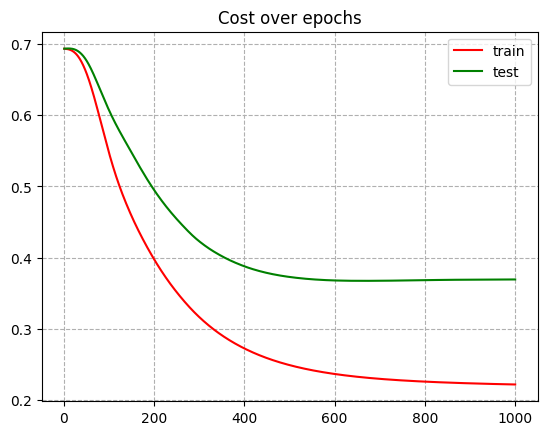

In [374]:
x = np.linspace(1,epochs,epochs)

plt.figure()
plt.plot(x,cost_list_train,color = 'red',label = 'train')
plt.plot(x,cost_list_test,color = 'green',label='test')
plt.title('Cost over epochs')
plt.grid(True,which="both", linestyle='--')
plt.legend()
plt.show()

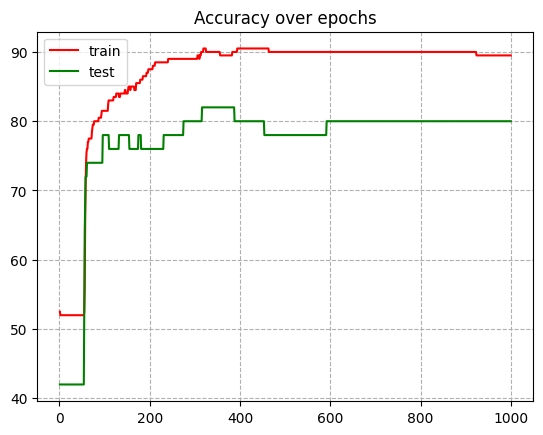

In [375]:
plt.figure()
plt.plot(x,accuracy_list_train,color = 'red',label = 'train')
plt.plot(x,accuracy_list_test,color = 'green',label='test')
plt.title('Accuracy over epochs')
plt.grid(True,which="both", linestyle='--')
plt.legend()
plt.show()